In [82]:
# imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from matplotlib.colors import LogNorm

In [93]:
class DataProcessor():
    def __init__(self, particle_one, particle_two, shuffle=True, train_prop=0.7, valid_prop=0.3, test_prop=0.1):
        super(DataProcessor,self).__init__()
        self.CLASS_ONE = particle_one
        self.CLASS_TWO = particle_two
        self.c1 = h5py.File('/fast_scratch_1/QVAE/data/calo/'+self.CLASS_ONE+'.hdf5', 'r')
        self.c2 = h5py.File('/fast_scratch_1/QVAE/data/calo/'+self.CLASS_TWO+'.hdf5', 'r') 
        self.gen_one = 'gen_'+particle_one
        self.gen_two = 'gen_'+particle_two
        self.shuffle = shuffle
        self.train_prop = train_prop
        self.valid_prop = valid_prop
        self.test_prop = test_prop
        self._BASE = '/home/s4hoque/DwaveSampInteg'
        # self.gen_piplus = self._BASE+'/CaloQVAE/outputs/2022-12-01/22-29-17/synthetic_images_piplus.pt'
        # self.gen_gamma = self._BASE+'/CaloQVAE/outputs/2022-11-30/18-02-26/synthetic_images_gamma.pt'
        # self.gen_eplus = self._BASE+'/CaloQVAE/outputs/2022-11-30/22-26-46/synthetic_images_eplus.pt'
        #self.gen_piplus = '/fast_scratch_1/CaloData/SyntheticImages/synthetic_images_piplus.pt'
        #self.gen_gamma = '/fast_scratch_1/CaloData/SyntheticImages/synthetic_images_gamma.pt'
        #self.gen_eplus = '/fast_scratch_1/CaloData/SyntheticImages/synthetic_images_eplus.pt'
        self.gen_piplus = '/fast_scratch_1/Scaled_synthetic_images/Synthetic_images_scaled_piplus.pt'
        self.gen_gamma = '/fast_scratch_1/Scaled_synthetic_images/Synthetic_images_scaled_gamma.pt'
        self.gen_eplus = '/fast_scratch_1/Scaled_synthetic_images/Synthetic_images_scaled_eplus.pt'
        
        self.gen_dict = {
            'gen_piplus': self.gen_piplus,
            'gen_gamma': self.gen_gamma,
            'gen_eplus': self.gen_eplus
        }
        
        
    def flattened_class_data(self, class_num):
        c_layer_0 = torch.tensor(np.array(class_num['layer_0']))
        c_layer_1 = torch.tensor(np.array(class_num['layer_1']))
        c_layer_2 = torch.tensor(np.array(class_num['layer_2']))
        c_flatten_0 = torch.flatten(c_layer_0, start_dim=1)
        c_flatten_1 = torch.flatten(c_layer_1, start_dim=1)
        c_flatten_2 = torch.flatten(c_layer_2, start_dim=1)
        flat_class_data = torch.cat((c_flatten_0,c_flatten_1,c_flatten_2), dim=1)
        return flat_class_data
    
    def get_synthetic_dataset(self):
        c1_dir = self.gen_dict[self.gen_one]
        c2_dir = self.gen_dict[self.gen_two]
        gen_c1_data = torch.load(c1_dir)
        gen_c2_data = torch.load(c2_dir)
        gen_c1_tensor = torch.cat(gen_c1_data) 
        gen_c2_tensor = torch.cat(gen_c2_data) 
        gen_c1_labels = torch.ones(gen_c1_tensor.size(0)) # ones
        gen_c2_labels = torch.zeros(gen_c2_tensor.size(0)) # zeros
        gen_dataset = torch.cat((gen_c1_tensor, gen_c2_tensor),dim=0)
        gen_targets = torch.cat((gen_c1_labels, gen_c2_labels), dim=0)
        # shuffle ...
        if self.shuffle==True:
            rand_perm = torch.randperm(gen_dataset.size(0))
            gen_dataset = gen_dataset[rand_perm].float()
            gen_targets = gen_targets[rand_perm]
        # may need to pass the synthetic inputs through a RELU
        gen_dataset = func.normalize(gen_dataset)
#         gen_cap = 60000
#         gen_dataset = gen_dataset[:60000]
#         gen_targets = gen_targets[:60000]
        print(gen_targets)
        return gen_dataset, gen_targets
          
    def get_geant_dataset(self):
        class_one_data = self.flattened_class_data(self.c1)
        class_two_data = self.flattened_class_data(self.c2)
        full_dataset = torch.cat((class_one_data, class_two_data), dim=0)
        # Getting labels
        c1_labels = torch.ones(class_one_data.size(0)) # ones
        c2_labels = torch.zeros(class_two_data.size(0)) # zeros
        targets = torch.cat((c1_labels, c2_labels), dim=0) # labels

        if self.shuffle==True:
            rand_perm = torch.randperm(full_dataset.size(0))
            full_dataset = full_dataset[rand_perm].float()
            targets = targets[rand_perm]
        full_dataset = func.normalize(full_dataset)
        return full_dataset, targets
    
    def train_test_split(self, geant = True):
        if geant==True: # split geant data
            full_dataset, targets = self.get_geant_dataset()
        else: # split synthetic data
            full_dataset, targets = self.get_synthetic_dataset()
        num_train_data = int(self.train_prop*full_dataset.size(0))
        train_data = full_dataset[:num_train_data]
        train_targets = targets[:num_train_data]
        valid_data = full_dataset[num_train_data:]
        valid_targets = targets[num_train_data:]
        return train_data, train_targets, valid_data, valid_targets

In [ ]:
CLASS_ONE = 'eplus'
CLASS_ONE2 = 'eplus'
unscaled = h5py.File('/fast_scratch_1/QVAE/data/calo/'+CLASS_ONE2+'.hdf5', 'r')
scaled = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/'+CLASS_ONE+'.hdf5', 'r')
sem_data = torch.load('/fast_scratch_1/CaloData/SyntheticImages/synthetic_images_'+CLASS_ONE2+'.pt')
gen_data = torch.load('/fast_scratch_1/Scaled_synthetic_images/Synthetic_images_scaled_'+CLASS_ONE+'.pt')
BASE = '/home/s4hoque/DwaveSampInteg'
#gen_data = torch.load(BASE+'/CaloQVAE/outputs/2022-12-01/22-29-17/synthetic_images_piplus.pt')
def flattened_data(class_num):
    c_layer_0 = torch.tensor(np.array(class_num['layer_0']))
    c_layer_1 = torch.tensor(np.array(class_num['layer_1']))
    c_layer_2 = torch.tensor(np.array(class_num['layer_2']))
    c_flatten_0 = torch.flatten(c_layer_0, start_dim=1)
    c_flatten_1 = torch.flatten(c_layer_1, start_dim=1)
    c_flatten_2 = torch.flatten(c_layer_2, start_dim=1)
    flat_class_data = torch.cat((c_flatten_0,c_flatten_1,c_flatten_2), dim=1)
    return flat_class_data

In [234]:
scaled_data = flattened_data(scaled)
unscaled_data = flattened_data(unscaled)

In [235]:
cat_data = torch.cat(gen_data)
sem_data = torch.cat(sem_data)

In [268]:
torch.max(unscaled_data)

tensor(24154.4883, dtype=torch.float64)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
plt.plot(unscaled_data[9058])

In [84]:
class Net(nn.Module):
    def __init__(self, num_features,  num_classes):
        super(Net, self).__init__() 
        self.fc1= nn.Linear(num_features, 512)
        self.nfc1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(p=0.2)
        
        self.fc2= nn.Linear(512, 1024)
        self.nfc2 = nn.BatchNorm1d(1024)
        self.drop2 = nn.Dropout(p=0.5)
        
        self.fc3= nn.Linear(1024, 2048)
        self.nfc3 = nn.BatchNorm1d(2048)
        self.drop3 = nn.Dropout(p=0.5)
        
        self.fc4= nn.Linear(2048, 1024)
        self.nfc4 = nn.BatchNorm1d(1024)
        self.drop4 = nn.Dropout(p=0.5)
        
        self.fc5= nn.Linear(1024, 128)
        self.nfc5 = nn.BatchNorm1d(128)
        self.drop5 = nn.Dropout(p=0.5)
        
        self.fc6= nn.Linear(128, num_classes)
        
    def forward(self, x):
        h1 = self.nfc1(self.drop1(func.leaky_relu(self.fc1(x)))) 
        h2 = self.nfc2(self.drop2(func.leaky_relu(self.fc2(h1))))
        h3 = self.nfc3(self.drop3(func.leaky_relu(self.fc3(h2))))
        h4 = self.nfc4(self.drop4(func.leaky_relu(self.fc4(h3))))
        h5 = self.drop5(func.leaky_relu(self.fc5(h4)))
        y = torch.sigmoid(self.fc6(h5))
        return y

In [94]:
def fit(particle_one, particle_two, geant_train = True, num_epochs=40, display_epochs=2, lr=0.075):
    model = Net(num_features=504, num_classes=1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.BCELoss(reduction= 'mean')
    obj_vals= []  
    train_accuracies = []
    valid_accuracies = []
    aux_accuracies = []
    dataloader =  DataProcessor(particle_one, particle_two)
    train_data, train_targets, valid_data, valid_targets = dataloader.train_test_split(geant=geant_train)
    print("Dimensions: train : {0}; target: {1}; valid: {2}; valid_target: {3}".format(train_data.size(), train_targets.size(), valid_data.size(), valid_targets.size()))
    if (geant_train==True):
        auxiliary_test_inputs, auxiliary_targets = dataloader.get_synthetic_dataset()
        print("Aux dim: input {0}".format(auxiliary_test_inputs.size()))
    else:
        auxiliary_test_inputs, auxiliary_targets = dataloader.get_geant_dataset()
    for epoch in range(num_epochs):   
        # train starts
        model.train()
        model_output = model.forward(train_data).reshape(-1)
        pred = (model_output>0.5).float()
        diff_tensor =  pred - train_targets 
        diff_tensor = torch.abs(diff_tensor)
        train_accuracy = 1-torch.sum(diff_tensor)/pred.size(0)
        train_accuracies.append(train_accuracy)
        model.eval()
        valid_output = model.forward(valid_data).reshape(-1)
        pred_valid = (valid_output>0.5).float()
        diff_tensor_valid =  pred_valid - valid_targets 
        diff_tensor_valid = torch.abs(diff_tensor_valid)
        valid_accuracy = 1-torch.sum(diff_tensor_valid)/pred_valid.size(0)
        valid_accuracies.append(valid_accuracy)
        # valid ends
        # begin auxiliary test
        model.eval() # precaution
        aux_output = model.forward(auxiliary_test_inputs).reshape(-1)
        pred_aux = (aux_output>0.5).float()
        diff_tensor_aux =  pred_aux - auxiliary_targets 
        diff_tensor_aux = torch.abs(diff_tensor_aux)
        aux_accuracy = 1-torch.sum(diff_tensor_aux)/pred_aux.size(0)
        aux_accuracies.append(aux_accuracy)   
        # end auxiliary test
        obj_val = loss(model_output, train_targets)
        optimizer.zero_grad() 
        obj_val.backward()
        optimizer.step() 
        obj_vals.append(obj_val.item())
        if (epoch+1) % display_epochs == 0:
            print ('Epoch [{}/{}]\tTrain Loss :{:.4f}\t train accuracy :{:.4f}%\t validation accuracy :{:.4f}%\t auxiliary class accuracy :{:.4f}%'.format(epoch+1, num_epochs, obj_val.item(), train_accuracy*100, valid_accuracy*100, aux_accuracy*100))
    print("\nTraining Completed")
    return obj_vals, train_accuracies, valid_accuracies, aux_accuracies, num_epochs, model

In [95]:
# Notes
# lr = 0.0004 is good for e+/gamma+ TRAIN using synthetic data
# MAYBE NEED TO INCREASE LEARNING RATE FOR GEANT_TRAINING with `gamma` & `eplus` particles probably try 0.01
# p+,e+ geant train (geant and synthetic test) -> 0.0005, 150 epochs more than enoughh
# e+/pi+ and e+/gamma

In [96]:
obj_vals, train_accuracies, valid_accuracies, aux_accuracies, num_epochs, model = fit(
    'gamma', 'eplus', 
    geant_train=True, 
    num_epochs=900,  
    display_epochs=50, 
    lr=0.0001     #0.00075
)

Dimensions: train : torch.Size([140000, 504]); target: torch.Size([140000]); valid: torch.Size([60000, 504]); valid_target: torch.Size([60000])
tensor([0., 1., 1.,  ..., 1., 1., 1.])
Aux dim: input torch.Size([286720, 504])
Epoch [50/900]	Train Loss :0.6243	 train accuracy :63.4600%	 validation accuracy :49.9817%	 auxiliary class accuracy :50.0000%
Epoch [100/900]	Train Loss :0.6181	 train accuracy :64.0493%	 validation accuracy :61.2683%	 auxiliary class accuracy :51.6643%
Epoch [150/900]	Train Loss :0.6090	 train accuracy :65.0186%	 validation accuracy :62.7567%	 auxiliary class accuracy :52.3061%
Epoch [200/900]	Train Loss :0.6004	 train accuracy :65.9157%	 validation accuracy :63.3733%	 auxiliary class accuracy :51.6818%
Epoch [250/900]	Train Loss :0.5953	 train accuracy :66.3307%	 validation accuracy :64.5467%	 auxiliary class accuracy :52.4306%
Epoch [300/900]	Train Loss :0.5918	 train accuracy :66.6371%	 validation accuracy :65.5617%	 auxiliary class accuracy :54.5075%
Epoch [35

# Analysis

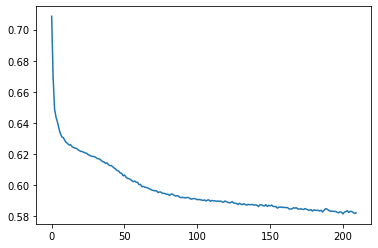

In [9]:
plt.plot(range(num_epochs), obj_vals) # plot loss function

Max geant accuracy: 0.6696 and max synthetic accuracy 0.6750


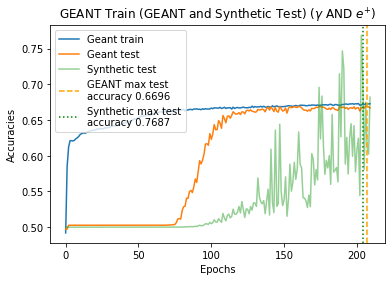

In [14]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and max synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

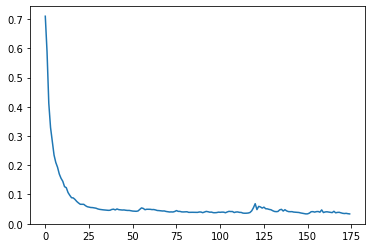

In [16]:
plt.plot(range(num_epochs), obj_vals) # plot loss function

Max synthetic accuracy: 0.9930 and max geant accuracy 0.5470


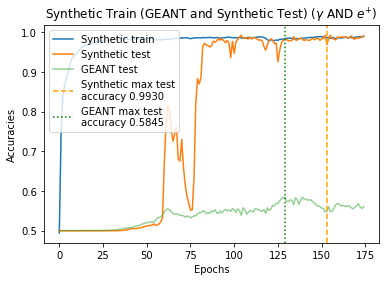

In [17]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Synthetic train")
plt.plot(range(num_epochs), valid_accuracies, label="Synthetic test")
plt.plot(range(num_epochs), aux_accuracies, label="GEANT test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="Synthetic max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="GEANT max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("Synthetic Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max synthetic accuracy: {:.4f} and max geant accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

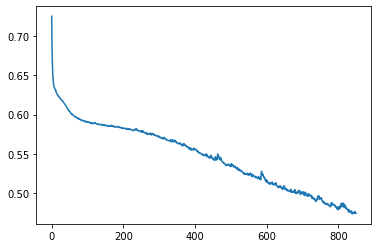

In [45]:
plt.plot(range(num_epochs), obj_vals) # plot loss function

Max geant accuracy: 0.6685 and max synthetic accuracy 0.7222


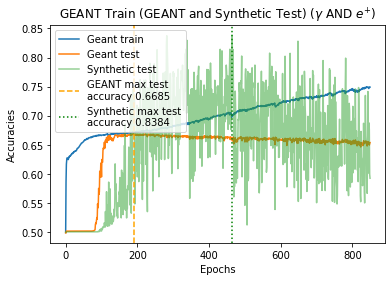

In [46]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and max synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

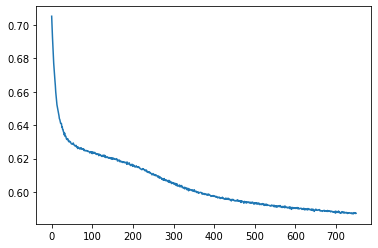

In [48]:
plt.plot(range(num_epochs), obj_vals) # plot loss function

Max geant accuracy: 0.6673 and corresponding synthetic accuracy 0.7117


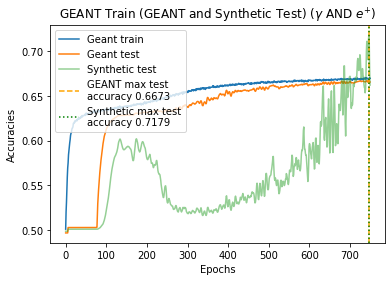

In [49]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and corresponding synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

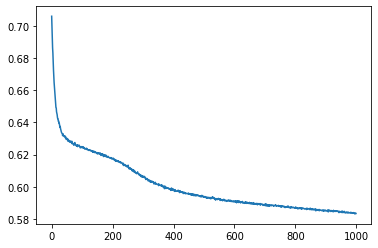

In [51]:
plt.plot(range(num_epochs), obj_vals) # plot loss function with 1000 epochs

Max geant accuracy: 0.6687 and corresponding synthetic accuracy 0.7939


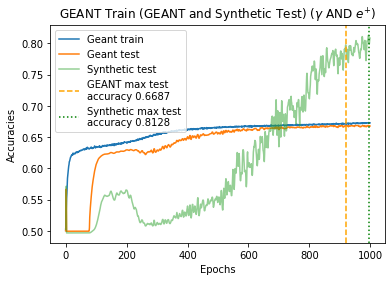

In [52]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and corresponding synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

Max geant accuracy: 0.6826 and corresponding synthetic accuracy 0.8405


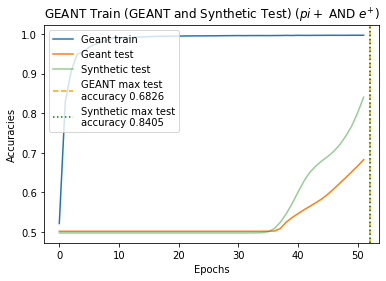

In [58]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("GEANT Train (GEANT and Synthetic Test) ($pi+$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and corresponding synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

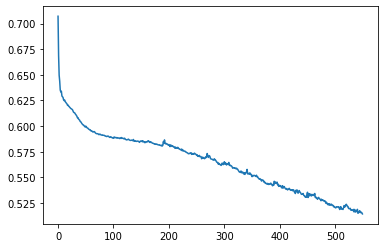

In [60]:
plt.plot(range(num_epochs), obj_vals) # plot loss function # might run

Max geant accuracy: 0.6706 and corresponding synthetic accuracy 0.7144


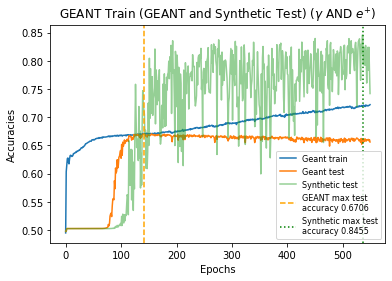

In [65]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="lower right", prop={'size': 8})
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and corresponding synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

Max synthetic accuracy: 0.9919 and max geant accuracy 0.5456


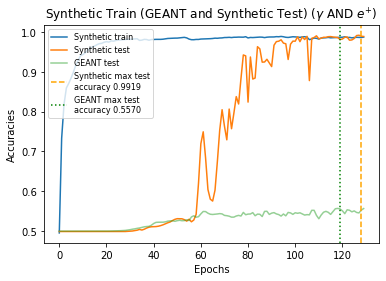

In [72]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Synthetic train")
plt.plot(range(num_epochs), valid_accuracies, label="Synthetic test")
plt.plot(range(num_epochs), aux_accuracies, label="GEANT test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="Synthetic max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="GEANT max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left", prop={'size': 8})
plt.title("Synthetic Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max synthetic accuracy: {:.4f} and max geant accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

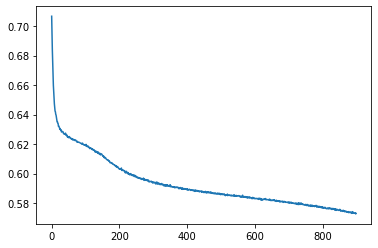

In [88]:
plt.plot(range(num_epochs), obj_vals) # plot loss function # morning run - 900 epochs -> 0.00008 -> synthetic test size = 30%

Max geant accuracy: 0.6689 and corresponding synthetic accuracy 0.8112


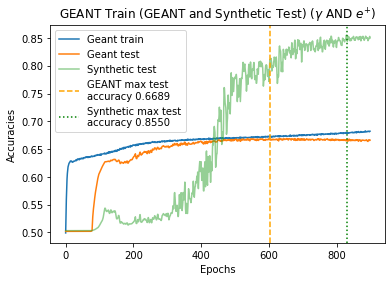

In [89]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and corresponding synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

In [91]:
for i in range(num_epochs):
    if i>300:
        print("{} Valid accuracy: {:.4f} and syn accuracy {:.4f}".format(i,valid_accuracies[i], aux_accuracies[i]))

301 Valid accuracy: 0.6543 and syn accuracy 0.5303
302 Valid accuracy: 0.6553 and syn accuracy 0.5343
303 Valid accuracy: 0.6554 and syn accuracy 0.5325
304 Valid accuracy: 0.6544 and syn accuracy 0.5269
305 Valid accuracy: 0.6524 and syn accuracy 0.5225
306 Valid accuracy: 0.6526 and syn accuracy 0.5246
307 Valid accuracy: 0.6533 and syn accuracy 0.5276
308 Valid accuracy: 0.6538 and syn accuracy 0.5293
309 Valid accuracy: 0.6542 and syn accuracy 0.5301
310 Valid accuracy: 0.6551 and syn accuracy 0.5324
311 Valid accuracy: 0.6552 and syn accuracy 0.5347
312 Valid accuracy: 0.6553 and syn accuracy 0.5351
313 Valid accuracy: 0.6551 and syn accuracy 0.5352
314 Valid accuracy: 0.6548 and syn accuracy 0.5340
315 Valid accuracy: 0.6561 and syn accuracy 0.5363
316 Valid accuracy: 0.6574 and syn accuracy 0.5411
317 Valid accuracy: 0.6586 and syn accuracy 0.5478
318 Valid accuracy: 0.6574 and syn accuracy 0.5451
319 Valid accuracy: 0.6564 and syn accuracy 0.5423
320 Valid accuracy: 0.6568 and 

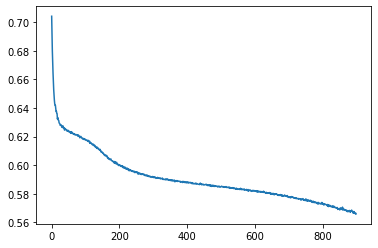

In [97]:
plt.plot(range(num_epochs), obj_vals) # plot loss function # morning run - 900 epochs -> 0.0001 -> synth test size = 100%

Max geant accuracy: 0.6670 and corresponding synthetic accuracy 0.7861


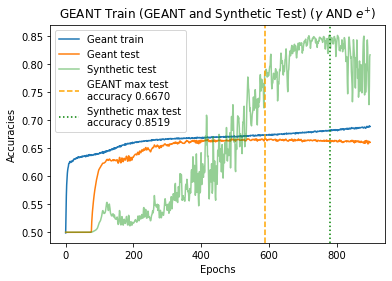

In [98]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="upper left")
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")
print("Max geant accuracy: {:.4f} and corresponding synthetic accuracy {:.4f}".format(max_valid_accuracy,aux_accuracies[max_valid_index-1]))

In [99]:
for i in range(num_epochs):
    if i>550 and i<600:
        print("{} Valid accuracy: {:.4f} and syn accuracy {:.4f}".format(i,valid_accuracies[i], aux_accuracies[i]))

551 Valid accuracy: 0.6660 and syn accuracy 0.7107
552 Valid accuracy: 0.6657 and syn accuracy 0.7138
553 Valid accuracy: 0.6653 and syn accuracy 0.7183
554 Valid accuracy: 0.6653 and syn accuracy 0.7402
555 Valid accuracy: 0.6659 and syn accuracy 0.7416
556 Valid accuracy: 0.6659 and syn accuracy 0.7273
557 Valid accuracy: 0.6651 and syn accuracy 0.7181
558 Valid accuracy: 0.6644 and syn accuracy 0.7261
559 Valid accuracy: 0.6658 and syn accuracy 0.7395
560 Valid accuracy: 0.6666 and syn accuracy 0.7547
561 Valid accuracy: 0.6660 and syn accuracy 0.7420
562 Valid accuracy: 0.6646 and syn accuracy 0.7217
563 Valid accuracy: 0.6660 and syn accuracy 0.7271
564 Valid accuracy: 0.6667 and syn accuracy 0.7372
565 Valid accuracy: 0.6653 and syn accuracy 0.7062
566 Valid accuracy: 0.6626 and syn accuracy 0.6916
567 Valid accuracy: 0.6639 and syn accuracy 0.7172
568 Valid accuracy: 0.6647 and syn accuracy 0.7385
569 Valid accuracy: 0.6646 and syn accuracy 0.7282
570 Valid accuracy: 0.6643 and 

Log -- Previous runs

In [ ]:
"""
geant train -> geant test and synthetic test -> got Max geant accuracy: 0.6696 and max synthetic accuracy 0.6750
Dimensions: train : torch.Size([140000, 504]); target: torch.Size([140000]); valid: torch.Size([60000, 504]); valid_target: torch.Size([60000])
tensor([1., 1., 1.,  ..., 0., 1., 0.])
Aux dim: input torch.Size([286720, 504])
Epoch [1/210]	Train Loss :0.7086	 train accuracy :49.1986%	 validation accuracy :49.7283%	 auxiliary class accuracy :50.0000%
Epoch [2/210]	Train Loss :0.6691	 train accuracy :58.4664%	 validation accuracy :49.7283%	 auxiliary class accuracy :50.0000%
Epoch [3/210]	Train Loss :0.6489	 train accuracy :61.1886%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [4/210]	Train Loss :0.6437	 train accuracy :62.1079%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [5/210]	Train Loss :0.6405	 train accuracy :62.1164%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [6/210]	Train Loss :0.6363	 train accuracy :62.0664%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [7/210]	Train Loss :0.6331	 train accuracy :62.1686%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [8/210]	Train Loss :0.6310	 train accuracy :62.3757%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [9/210]	Train Loss :0.6306	 train accuracy :62.5164%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [10/210]	Train Loss :0.6288	 train accuracy :62.7100%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [11/210]	Train Loss :0.6275	 train accuracy :62.9900%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [12/210]	Train Loss :0.6267	 train accuracy :63.0850%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [13/210]	Train Loss :0.6258	 train accuracy :63.2136%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [14/210]	Train Loss :0.6260	 train accuracy :63.1614%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [15/210]	Train Loss :0.6248	 train accuracy :63.2064%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [16/210]	Train Loss :0.6242	 train accuracy :63.3500%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [17/210]	Train Loss :0.6238	 train accuracy :63.3714%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [18/210]	Train Loss :0.6236	 train accuracy :63.4964%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [19/210]	Train Loss :0.6228	 train accuracy :63.5093%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [20/210]	Train Loss :0.6222	 train accuracy :63.5707%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [21/210]	Train Loss :0.6216	 train accuracy :63.5857%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [22/210]	Train Loss :0.6216	 train accuracy :63.6786%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [23/210]	Train Loss :0.6211	 train accuracy :63.7614%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [24/210]	Train Loss :0.6207	 train accuracy :63.7271%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [25/210]	Train Loss :0.6205	 train accuracy :63.8407%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [26/210]	Train Loss :0.6196	 train accuracy :63.7364%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [27/210]	Train Loss :0.6192	 train accuracy :63.8107%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [28/210]	Train Loss :0.6188	 train accuracy :63.9179%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [29/210]	Train Loss :0.6184	 train accuracy :63.8771%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [30/210]	Train Loss :0.6185	 train accuracy :63.9357%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [31/210]	Train Loss :0.6180	 train accuracy :63.9614%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [32/210]	Train Loss :0.6173	 train accuracy :64.0743%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [33/210]	Train Loss :0.6170	 train accuracy :64.1486%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [34/210]	Train Loss :0.6168	 train accuracy :64.1514%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [35/210]	Train Loss :0.6159	 train accuracy :64.1979%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [36/210]	Train Loss :0.6151	 train accuracy :64.2429%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [37/210]	Train Loss :0.6149	 train accuracy :64.2500%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [38/210]	Train Loss :0.6140	 train accuracy :64.3493%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [39/210]	Train Loss :0.6143	 train accuracy :64.4064%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [40/210]	Train Loss :0.6131	 train accuracy :64.4507%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [41/210]	Train Loss :0.6125	 train accuracy :64.5850%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [42/210]	Train Loss :0.6126	 train accuracy :64.5986%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [43/210]	Train Loss :0.6117	 train accuracy :64.7221%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [44/210]	Train Loss :0.6109	 train accuracy :64.7536%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [45/210]	Train Loss :0.6103	 train accuracy :64.7407%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [46/210]	Train Loss :0.6094	 train accuracy :64.9400%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [47/210]	Train Loss :0.6091	 train accuracy :65.0021%	 validation accuracy :50.2717%	 auxiliary class accuracy :50.0000%
Epoch [48/210]	Train Loss :0.6078	 train accuracy :65.1629%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [49/210]	Train Loss :0.6076	 train accuracy :65.1329%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [50/210]	Train Loss :0.6060	 train accuracy :65.2350%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [51/210]	Train Loss :0.6066	 train accuracy :65.3086%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [52/210]	Train Loss :0.6053	 train accuracy :65.4543%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [53/210]	Train Loss :0.6044	 train accuracy :65.5457%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [54/210]	Train Loss :0.6042	 train accuracy :65.5536%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [55/210]	Train Loss :0.6038	 train accuracy :65.5829%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [56/210]	Train Loss :0.6029	 train accuracy :65.5921%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [57/210]	Train Loss :0.6022	 train accuracy :65.8086%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [58/210]	Train Loss :0.6026	 train accuracy :65.7171%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [59/210]	Train Loss :0.6019	 train accuracy :65.6893%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [60/210]	Train Loss :0.6018	 train accuracy :65.7307%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [61/210]	Train Loss :0.6003	 train accuracy :65.8771%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [62/210]	Train Loss :0.6005	 train accuracy :65.8829%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [63/210]	Train Loss :0.5989	 train accuracy :66.0150%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [64/210]	Train Loss :0.5993	 train accuracy :66.0636%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [65/210]	Train Loss :0.5986	 train accuracy :66.0750%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0000%
Epoch [66/210]	Train Loss :0.5986	 train accuracy :66.1750%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0003%
Epoch [67/210]	Train Loss :0.5982	 train accuracy :66.1471%	 validation accuracy :50.2733%	 auxiliary class accuracy :50.0003%
Epoch [68/210]	Train Loss :0.5977	 train accuracy :66.0521%	 validation accuracy :50.2750%	 auxiliary class accuracy :50.0014%
Epoch [69/210]	Train Loss :0.5972	 train accuracy :66.1543%	 validation accuracy :50.2767%	 auxiliary class accuracy :50.0014%
Epoch [70/210]	Train Loss :0.5968	 train accuracy :66.3014%	 validation accuracy :50.2817%	 auxiliary class accuracy :50.0021%
Epoch [71/210]	Train Loss :0.5965	 train accuracy :66.2743%	 validation accuracy :50.2900%	 auxiliary class accuracy :50.0028%
Epoch [72/210]	Train Loss :0.5964	 train accuracy :66.1550%	 validation accuracy :50.2967%	 auxiliary class accuracy :50.0035%
Epoch [73/210]	Train Loss :0.5964	 train accuracy :66.2150%	 validation accuracy :50.3183%	 auxiliary class accuracy :50.0049%
Epoch [74/210]	Train Loss :0.5952	 train accuracy :66.2071%	 validation accuracy :50.3317%	 auxiliary class accuracy :50.0059%
Epoch [75/210]	Train Loss :0.5956	 train accuracy :66.3164%	 validation accuracy :50.3417%	 auxiliary class accuracy :50.0066%
Epoch [76/210]	Train Loss :0.5956	 train accuracy :66.2729%	 validation accuracy :50.3867%	 auxiliary class accuracy :50.0070%
Epoch [77/210]	Train Loss :0.5947	 train accuracy :66.3957%	 validation accuracy :50.6433%	 auxiliary class accuracy :50.0094%
Epoch [78/210]	Train Loss :0.5948	 train accuracy :66.2771%	 validation accuracy :51.1517%	 auxiliary class accuracy :50.0133%
Epoch [79/210]	Train Loss :0.5945	 train accuracy :66.3593%	 validation accuracy :51.2017%	 auxiliary class accuracy :50.0147%
Epoch [80/210]	Train Loss :0.5941	 train accuracy :66.3807%	 validation accuracy :51.1300%	 auxiliary class accuracy :50.0143%
Epoch [81/210]	Train Loss :0.5941	 train accuracy :66.4136%	 validation accuracy :52.3117%	 auxiliary class accuracy :50.0223%
Epoch [82/210]	Train Loss :0.5934	 train accuracy :66.5057%	 validation accuracy :52.8750%	 auxiliary class accuracy :50.0303%
Epoch [83/210]	Train Loss :0.5942	 train accuracy :66.2650%	 validation accuracy :52.9333%	 auxiliary class accuracy :50.0307%
Epoch [84/210]	Train Loss :0.5942	 train accuracy :66.4100%	 validation accuracy :54.0600%	 auxiliary class accuracy :50.0593%
Epoch [85/210]	Train Loss :0.5936	 train accuracy :66.4136%	 validation accuracy :54.0300%	 auxiliary class accuracy :50.0558%
Epoch [86/210]	Train Loss :0.5929	 train accuracy :66.4814%	 validation accuracy :54.9850%	 auxiliary class accuracy :50.0823%
Epoch [87/210]	Train Loss :0.5932	 train accuracy :66.4879%	 validation accuracy :55.1550%	 auxiliary class accuracy :50.0806%
Epoch [88/210]	Train Loss :0.5930	 train accuracy :66.4350%	 validation accuracy :54.8500%	 auxiliary class accuracy :50.0610%
Epoch [89/210]	Train Loss :0.5922	 train accuracy :66.5436%	 validation accuracy :55.6650%	 auxiliary class accuracy :50.0827%
Epoch [90/210]	Train Loss :0.5920	 train accuracy :66.5322%	 validation accuracy :56.7483%	 auxiliary class accuracy :50.1315%
Epoch [91/210]	Train Loss :0.5922	 train accuracy :66.5686%	 validation accuracy :56.2650%	 auxiliary class accuracy :50.0987%
Epoch [92/210]	Train Loss :0.5919	 train accuracy :66.5043%	 validation accuracy :57.8317%	 auxiliary class accuracy :50.1772%
Epoch [93/210]	Train Loss :0.5918	 train accuracy :66.5150%	 validation accuracy :59.3167%	 auxiliary class accuracy :50.2783%
Epoch [94/210]	Train Loss :0.5921	 train accuracy :66.4486%	 validation accuracy :58.8517%	 auxiliary class accuracy :50.1992%
Epoch [95/210]	Train Loss :0.5919	 train accuracy :66.5800%	 validation accuracy :59.4000%	 auxiliary class accuracy :50.2274%
Epoch [96/210]	Train Loss :0.5914	 train accuracy :66.4986%	 validation accuracy :60.2133%	 auxiliary class accuracy :50.3076%
Epoch [97/210]	Train Loss :0.5909	 train accuracy :66.5886%	 validation accuracy :61.6383%	 auxiliary class accuracy :50.4844%
Epoch [98/210]	Train Loss :0.5913	 train accuracy :66.5500%	 validation accuracy :61.6867%	 auxiliary class accuracy :50.4586%
Epoch [99/210]	Train Loss :0.5914	 train accuracy :66.5336%	 validation accuracy :61.4733%	 auxiliary class accuracy :50.3965%
Epoch [100/210]	Train Loss :0.5911	 train accuracy :66.5514%	 validation accuracy :63.1067%	 auxiliary class accuracy :50.6543%
Epoch [101/210]	Train Loss :0.5906	 train accuracy :66.6714%	 validation accuracy :62.3017%	 auxiliary class accuracy :50.4994%
Epoch [102/210]	Train Loss :0.5908	 train accuracy :66.5950%	 validation accuracy :63.0467%	 auxiliary class accuracy :50.6184%
Epoch [103/210]	Train Loss :0.5906	 train accuracy :66.7100%	 validation accuracy :64.3600%	 auxiliary class accuracy :51.0379%
Epoch [104/210]	Train Loss :0.5904	 train accuracy :66.7000%	 validation accuracy :63.6417%	 auxiliary class accuracy :50.7373%
Epoch [105/210]	Train Loss :0.5901	 train accuracy :66.6914%	 validation accuracy :63.6567%	 auxiliary class accuracy :50.6961%
Epoch [106/210]	Train Loss :0.5905	 train accuracy :66.6650%	 validation accuracy :64.9150%	 auxiliary class accuracy :51.1911%
Epoch [107/210]	Train Loss :0.5898	 train accuracy :66.7821%	 validation accuracy :64.6033%	 auxiliary class accuracy :50.9434%
Epoch [108/210]	Train Loss :0.5904	 train accuracy :66.6171%	 validation accuracy :63.8517%	 auxiliary class accuracy :50.6794%
Epoch [109/210]	Train Loss :0.5905	 train accuracy :66.6814%	 validation accuracy :65.6367%	 auxiliary class accuracy :51.9186%
Epoch [110/210]	Train Loss :0.5896	 train accuracy :66.7929%	 validation accuracy :65.2217%	 auxiliary class accuracy :51.2995%
Epoch [111/210]	Train Loss :0.5902	 train accuracy :66.6179%	 validation accuracy :64.6150%	 auxiliary class accuracy :50.8897%
Epoch [112/210]	Train Loss :0.5899	 train accuracy :66.7121%	 validation accuracy :65.5117%	 auxiliary class accuracy :51.6417%
Epoch [113/210]	Train Loss :0.5899	 train accuracy :66.7036%	 validation accuracy :65.5883%	 auxiliary class accuracy :51.8290%
Epoch [114/210]	Train Loss :0.5896	 train accuracy :66.7321%	 validation accuracy :65.2533%	 auxiliary class accuracy :51.3065%
Epoch [115/210]	Train Loss :0.5898	 train accuracy :66.5429%	 validation accuracy :65.6450%	 auxiliary class accuracy :51.5102%
Epoch [116/210]	Train Loss :0.5896	 train accuracy :66.8043%	 validation accuracy :66.1633%	 auxiliary class accuracy :52.5174%
Epoch [117/210]	Train Loss :0.5898	 train accuracy :66.6157%	 validation accuracy :65.9683%	 auxiliary class accuracy :51.8258%
Epoch [118/210]	Train Loss :0.5892	 train accuracy :66.7193%	 validation accuracy :65.8183%	 auxiliary class accuracy :51.8108%
Epoch [119/210]	Train Loss :0.5890	 train accuracy :66.7557%	 validation accuracy :65.8683%	 auxiliary class accuracy :52.1048%
Epoch [120/210]	Train Loss :0.5898	 train accuracy :66.6957%	 validation accuracy :66.0333%	 auxiliary class accuracy :52.8986%
Epoch [121/210]	Train Loss :0.5893	 train accuracy :66.6936%	 validation accuracy :65.7683%	 auxiliary class accuracy :51.9932%
Epoch [122/210]	Train Loss :0.5890	 train accuracy :66.7564%	 validation accuracy :66.1467%	 auxiliary class accuracy :53.6000%
Epoch [123/210]	Train Loss :0.5886	 train accuracy :66.8171%	 validation accuracy :66.1183%	 auxiliary class accuracy :52.4770%
Epoch [124/210]	Train Loss :0.5888	 train accuracy :66.7300%	 validation accuracy :65.8683%	 auxiliary class accuracy :51.3630%
Epoch [125/210]	Train Loss :0.5894	 train accuracy :66.7286%	 validation accuracy :66.3033%	 auxiliary class accuracy :52.5708%
Epoch [126/210]	Train Loss :0.5884	 train accuracy :66.7207%	 validation accuracy :66.3850%	 auxiliary class accuracy :52.4920%
Epoch [127/210]	Train Loss :0.5884	 train accuracy :66.7750%	 validation accuracy :66.2733%	 auxiliary class accuracy :51.8788%
Epoch [128/210]	Train Loss :0.5882	 train accuracy :66.7393%	 validation accuracy :66.4200%	 auxiliary class accuracy :52.8945%
Epoch [129/210]	Train Loss :0.5875	 train accuracy :66.9379%	 validation accuracy :66.2367%	 auxiliary class accuracy :52.3908%
Epoch [130/210]	Train Loss :0.5883	 train accuracy :66.7629%	 validation accuracy :66.1917%	 auxiliary class accuracy :53.4079%
Epoch [131/210]	Train Loss :0.5878	 train accuracy :66.8857%	 validation accuracy :66.0967%	 auxiliary class accuracy :53.3740%
Epoch [132/210]	Train Loss :0.5874	 train accuracy :66.8250%	 validation accuracy :66.1550%	 auxiliary class accuracy :52.9150%
Epoch [133/210]	Train Loss :0.5881	 train accuracy :66.8529%	 validation accuracy :66.4967%	 auxiliary class accuracy :56.9008%
Epoch [134/210]	Train Loss :0.5875	 train accuracy :66.8514%	 validation accuracy :66.4100%	 auxiliary class accuracy :54.2721%
Epoch [135/210]	Train Loss :0.5872	 train accuracy :66.9179%	 validation accuracy :66.4400%	 auxiliary class accuracy :53.5261%
Epoch [136/210]	Train Loss :0.5877	 train accuracy :66.8150%	 validation accuracy :66.5400%	 auxiliary class accuracy :53.2795%
Epoch [137/210]	Train Loss :0.5874	 train accuracy :66.9314%	 validation accuracy :66.4417%	 auxiliary class accuracy :53.7134%
Epoch [138/210]	Train Loss :0.5875	 train accuracy :66.8236%	 validation accuracy :66.1467%	 auxiliary class accuracy :51.8876%
Epoch [139/210]	Train Loss :0.5875	 train accuracy :66.7964%	 validation accuracy :66.6233%	 auxiliary class accuracy :53.6869%
Epoch [140/210]	Train Loss :0.5871	 train accuracy :66.9114%	 validation accuracy :66.7850%	 auxiliary class accuracy :55.3188%
Epoch [141/210]	Train Loss :0.5873	 train accuracy :66.8214%	 validation accuracy :66.3917%	 auxiliary class accuracy :51.6999%
Epoch [142/210]	Train Loss :0.5870	 train accuracy :66.8171%	 validation accuracy :66.8383%	 auxiliary class accuracy :60.9222%
Epoch [143/210]	Train Loss :0.5862	 train accuracy :66.9893%	 validation accuracy :66.5483%	 auxiliary class accuracy :53.4535%
Epoch [144/210]	Train Loss :0.5873	 train accuracy :66.8507%	 validation accuracy :66.1883%	 auxiliary class accuracy :52.0459%
Epoch [145/210]	Train Loss :0.5875	 train accuracy :66.9100%	 validation accuracy :66.7633%	 auxiliary class accuracy :63.6028%
Epoch [146/210]	Train Loss :0.5869	 train accuracy :66.9821%	 validation accuracy :66.2233%	 auxiliary class accuracy :52.9217%
Epoch [147/210]	Train Loss :0.5866	 train accuracy :66.8686%	 validation accuracy :66.1033%	 auxiliary class accuracy :53.2767%
Epoch [148/210]	Train Loss :0.5874	 train accuracy :66.8843%	 validation accuracy :66.8500%	 auxiliary class accuracy :64.4095%
Epoch [149/210]	Train Loss :0.5863	 train accuracy :66.8743%	 validation accuracy :66.5983%	 auxiliary class accuracy :54.9390%
Epoch [150/210]	Train Loss :0.5871	 train accuracy :66.8693%	 validation accuracy :66.2517%	 auxiliary class accuracy :53.0089%
Epoch [151/210]	Train Loss :0.5866	 train accuracy :66.8922%	 validation accuracy :66.3533%	 auxiliary class accuracy :53.8347%
Epoch [152/210]	Train Loss :0.5872	 train accuracy :66.9136%	 validation accuracy :66.6750%	 auxiliary class accuracy :57.0501%
Epoch [153/210]	Train Loss :0.5863	 train accuracy :66.9636%	 validation accuracy :65.9667%	 auxiliary class accuracy :51.5318%
Epoch [154/210]	Train Loss :0.5863	 train accuracy :67.0150%	 validation accuracy :66.6500%	 auxiliary class accuracy :53.8602%
Epoch [155/210]	Train Loss :0.5862	 train accuracy :66.9757%	 validation accuracy :66.8567%	 auxiliary class accuracy :58.8215%
Epoch [156/210]	Train Loss :0.5852	 train accuracy :66.9514%	 validation accuracy :66.7350%	 auxiliary class accuracy :55.0401%
Epoch [157/210]	Train Loss :0.5858	 train accuracy :66.9171%	 validation accuracy :66.7867%	 auxiliary class accuracy :56.2706%
Epoch [158/210]	Train Loss :0.5858	 train accuracy :66.9786%	 validation accuracy :66.9200%	 auxiliary class accuracy :59.0820%
Epoch [159/210]	Train Loss :0.5860	 train accuracy :67.0429%	 validation accuracy :66.7833%	 auxiliary class accuracy :56.6968%
Epoch [160/210]	Train Loss :0.5856	 train accuracy :66.9750%	 validation accuracy :66.7600%	 auxiliary class accuracy :58.0587%
Epoch [161/210]	Train Loss :0.5857	 train accuracy :66.9443%	 validation accuracy :66.9183%	 auxiliary class accuracy :63.3364%
Epoch [162/210]	Train Loss :0.5855	 train accuracy :67.0779%	 validation accuracy :66.8500%	 auxiliary class accuracy :58.8065%
Epoch [163/210]	Train Loss :0.5856	 train accuracy :67.0671%	 validation accuracy :66.7333%	 auxiliary class accuracy :58.3266%
Epoch [164/210]	Train Loss :0.5847	 train accuracy :67.0657%	 validation accuracy :66.4817%	 auxiliary class accuracy :54.1371%
Epoch [165/210]	Train Loss :0.5847	 train accuracy :67.0529%	 validation accuracy :66.3783%	 auxiliary class accuracy :54.0667%
Epoch [166/210]	Train Loss :0.5848	 train accuracy :67.0029%	 validation accuracy :66.3900%	 auxiliary class accuracy :53.6991%
Epoch [167/210]	Train Loss :0.5854	 train accuracy :67.0071%	 validation accuracy :66.2417%	 auxiliary class accuracy :52.7532%
Epoch [168/210]	Train Loss :0.5852	 train accuracy :67.0679%	 validation accuracy :66.4267%	 auxiliary class accuracy :54.4999%
Epoch [169/210]	Train Loss :0.5855	 train accuracy :67.0407%	 validation accuracy :66.2717%	 auxiliary class accuracy :52.8704%
Epoch [170/210]	Train Loss :0.5847	 train accuracy :67.1064%	 validation accuracy :66.6450%	 auxiliary class accuracy :60.3052%
Epoch [171/210]	Train Loss :0.5845	 train accuracy :67.0936%	 validation accuracy :66.6033%	 auxiliary class accuracy :59.5393%
Epoch [172/210]	Train Loss :0.5849	 train accuracy :67.0850%	 validation accuracy :66.6350%	 auxiliary class accuracy :55.9246%
Epoch [173/210]	Train Loss :0.5845	 train accuracy :67.0643%	 validation accuracy :66.8167%	 auxiliary class accuracy :58.0556%
Epoch [174/210]	Train Loss :0.5843	 train accuracy :67.1000%	 validation accuracy :66.7483%	 auxiliary class accuracy :56.6044%
Epoch [175/210]	Train Loss :0.5849	 train accuracy :67.0557%	 validation accuracy :66.8667%	 auxiliary class accuracy :69.5874%
Epoch [176/210]	Train Loss :0.5845	 train accuracy :67.0714%	 validation accuracy :66.8850%	 auxiliary class accuracy :62.3542%
Epoch [177/210]	Train Loss :0.5840	 train accuracy :67.1021%	 validation accuracy :66.8217%	 auxiliary class accuracy :68.3566%
Epoch [178/210]	Train Loss :0.5839	 train accuracy :67.1514%	 validation accuracy :66.8067%	 auxiliary class accuracy :61.4164%
Epoch [179/210]	Train Loss :0.5843	 train accuracy :67.1193%	 validation accuracy :66.7067%	 auxiliary class accuracy :57.3961%
Epoch [180/210]	Train Loss :0.5833	 train accuracy :67.1521%	 validation accuracy :66.5467%	 auxiliary class accuracy :59.3722%
Epoch [181/210]	Train Loss :0.5841	 train accuracy :67.0664%	 validation accuracy :66.4867%	 auxiliary class accuracy :58.2917%
Epoch [182/210]	Train Loss :0.5839	 train accuracy :67.1800%	 validation accuracy :66.6667%	 auxiliary class accuracy :60.0244%
Epoch [183/210]	Train Loss :0.5838	 train accuracy :67.2079%	 validation accuracy :66.4833%	 auxiliary class accuracy :56.0003%
Epoch [184/210]	Train Loss :0.5838	 train accuracy :67.1100%	 validation accuracy :66.7367%	 auxiliary class accuracy :65.7865%
Epoch [185/210]	Train Loss :0.5834	 train accuracy :67.0429%	 validation accuracy :66.6817%	 auxiliary class accuracy :57.7183%
Epoch [186/210]	Train Loss :0.5838	 train accuracy :67.1714%	 validation accuracy :66.4767%	 auxiliary class accuracy :57.9677%
Epoch [187/210]	Train Loss :0.5827	 train accuracy :67.1643%	 validation accuracy :66.4267%	 auxiliary class accuracy :58.3538%
Epoch [188/210]	Train Loss :0.5838	 train accuracy :67.0707%	 validation accuracy :66.3433%	 auxiliary class accuracy :56.3382%
Epoch [189/210]	Train Loss :0.5848	 train accuracy :67.0971%	 validation accuracy :66.8367%	 auxiliary class accuracy :71.4791%
Epoch [190/210]	Train Loss :0.5847	 train accuracy :67.0779%	 validation accuracy :66.7833%	 auxiliary class accuracy :62.6583%
Epoch [191/210]	Train Loss :0.5839	 train accuracy :67.1871%	 validation accuracy :66.7650%	 auxiliary class accuracy :74.6788%
Epoch [192/210]	Train Loss :0.5834	 train accuracy :67.1850%	 validation accuracy :66.8267%	 auxiliary class accuracy :72.2381%
Epoch [193/210]	Train Loss :0.5832	 train accuracy :67.2429%	 validation accuracy :66.6300%	 auxiliary class accuracy :58.8396%
Epoch [194/210]	Train Loss :0.5833	 train accuracy :67.2350%	 validation accuracy :66.7583%	 auxiliary class accuracy :62.5701%
Epoch [195/210]	Train Loss :0.5831	 train accuracy :67.1800%	 validation accuracy :66.5067%	 auxiliary class accuracy :57.4599%
Epoch [196/210]	Train Loss :0.5831	 train accuracy :67.2629%	 validation accuracy :66.6883%	 auxiliary class accuracy :62.5631%
Epoch [197/210]	Train Loss :0.5825	 train accuracy :67.2486%	 validation accuracy :66.7267%	 auxiliary class accuracy :64.4786%
Epoch [198/210]	Train Loss :0.5822	 train accuracy :67.2893%	 validation accuracy :66.6183%	 auxiliary class accuracy :59.9296%
Epoch [199/210]	Train Loss :0.5829	 train accuracy :67.2129%	 validation accuracy :66.8550%	 auxiliary class accuracy :64.2254%
Epoch [200/210]	Train Loss :0.5826	 train accuracy :67.2864%	 validation accuracy :66.5367%	 auxiliary class accuracy :57.7536%
Epoch [201/210]	Train Loss :0.5815	 train accuracy :67.2557%	 validation accuracy :66.7100%	 auxiliary class accuracy :60.8357%
Epoch [202/210]	Train Loss :0.5826	 train accuracy :67.3179%	 validation accuracy :66.7300%	 auxiliary class accuracy :62.4393%
Epoch [203/210]	Train Loss :0.5830	 train accuracy :67.0700%	 validation accuracy :66.2667%	 auxiliary class accuracy :54.4441%
Epoch [204/210]	Train Loss :0.5836	 train accuracy :67.1164%	 validation accuracy :66.7483%	 auxiliary class accuracy :76.8719%
Epoch [205/210]	Train Loss :0.5824	 train accuracy :67.2271%	 validation accuracy :66.6950%	 auxiliary class accuracy :71.3623%
Epoch [206/210]	Train Loss :0.5832	 train accuracy :67.1593%	 validation accuracy :66.6517%	 auxiliary class accuracy :58.1058%
Epoch [207/210]	Train Loss :0.5830	 train accuracy :67.2950%	 validation accuracy :66.9650%	 auxiliary class accuracy :67.5045%
Epoch [208/210]	Train Loss :0.5825	 train accuracy :67.2307%	 validation accuracy :66.9200%	 auxiliary class accuracy :61.1670%
Epoch [209/210]	Train Loss :0.5818	 train accuracy :67.2650%	 validation accuracy :66.8317%	 auxiliary class accuracy :60.2368%
Epoch [210/210]	Train Loss :0.5822	 train accuracy :67.2836%	 validation accuracy :66.7017%	 auxiliary class accuracy :68.1986%

Training Completed
"""

In [ ]:
"""
Geant train -> geant & synthetic test: 


"""